In [1]:
# Load libraries
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics 

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

In [2]:
data=pd.read_csv("https://raw.githubusercontent.com/huynhthanh98/ML/master/lab-07/bt2.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
X_train, X_test, y_train, y_test = train_test_split(data[data.columns.difference(["Outcome"])], data["Outcome"], test_size=0.3, random_state=1) # 70% training and 30% test


### 1. Hãy thử thay đổi Max_depth để tăng accuracy trên tập testing, vẽ cây với Max_depth đã thay đổi.


In [4]:
tree_model1 = DecisionTreeClassifier(criterion='gini', max_depth= 3 , random_state = 1, max_features=None) 

tree_model1 .fit(X_train, y_train)
accuracy = tree_model1.score(X_test,y_test)
print('Model accuracy score : {0:0.4f}'. format(accuracy))


Model accuracy score : 0.7576


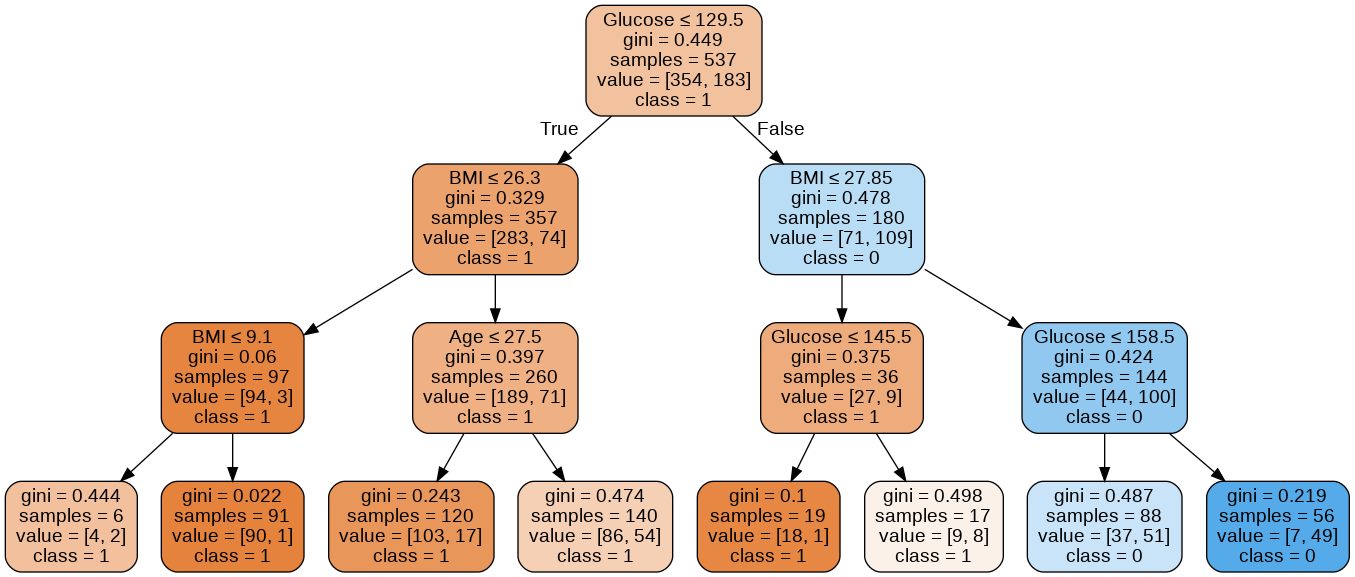

In [5]:
dot_data = StringIO()
export_graphviz(tree_model1, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=X_train.columns,class_names=list(y_train.astype('str').unique()))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes1.png')
Image(graph.create_png())

In [6]:
tree_model2 = DecisionTreeClassifier(criterion='gini', max_depth= 5 , random_state = 1, max_features=None) 

tree_model2 .fit(X_train, y_train)
accuracy = tree_model2.score(X_test,y_test)
print('Model accuracy score : {0:0.4f}'. format(accuracy))

Model accuracy score : 0.7749


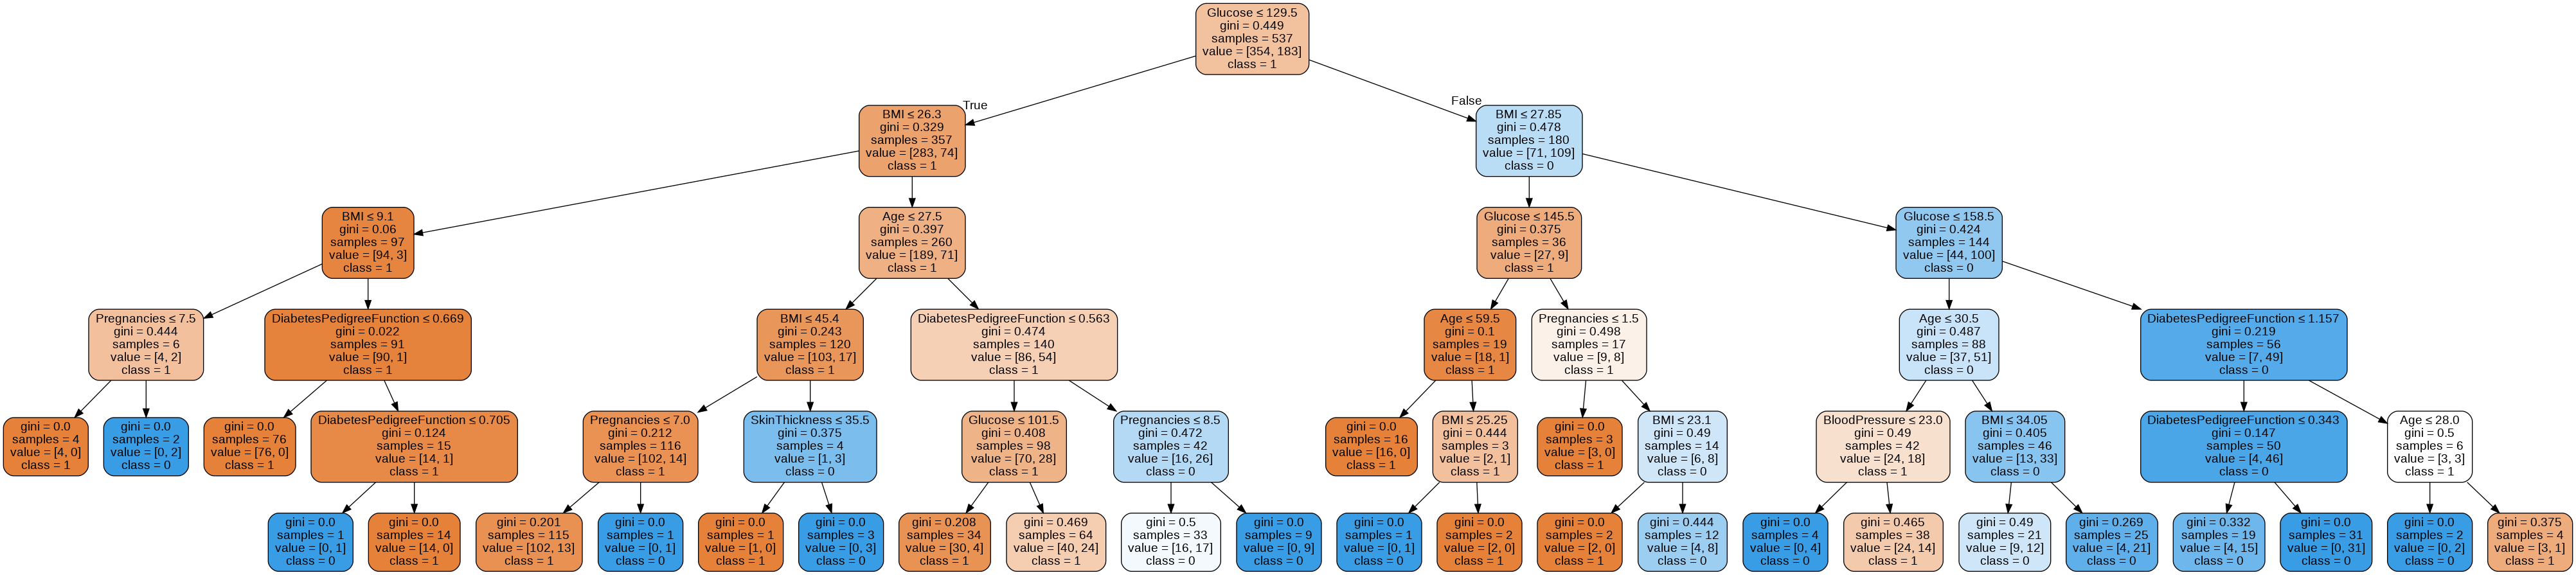

In [7]:
dot_data = StringIO()
export_graphviz(tree_model2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=X_train.columns,class_names=list(y_train.astype('str').unique()))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes2.png')
Image(graph.create_png())

### 2. max_depth ảnh hưởng như thế nào đối với mô hình decision tree, vì sao?


**Max depth** như tên của nó là chiều sâu lớn nhất mà ta cho cây phát triển. Cây càng lớn thì độ phức tạp thuật toán càng cao. 

Đối với quá trình huấn luyện dữ liệu, nếu ta cho cây mọc càng sâu thì dễ dàng thấy hàm mất mát trong tập train sẽ càng nhỏ. Tuy nhiên, việc này dẫn đến mô hình chỉ học tốt trên tập train và khả năng cao học tệ trên tập test hay nói cách khác là overfitting. 

Còn nếu ta cho chiều sâu của cây nhỏ thì điều này cũng không tốt vì mô hình quá đơn giản dẫn đến không học tốt trên lẫn tập train và test (underfitting).Vì vậy ta phải lựa chọn chiều sâu của cây sao cho chúng không quá sâu cũng như quá không quá ngắn để có mô hình tốt nhất.

### 3. Dùng dataset bên dưới, từ mô hình Decision Tree hãy code thêm mô hình Random Forest như thuật toán đã học. Thử tìm hiểu cách dùng Random Forest trong sklearn để so sánh kết quả.

**Thuật toán Random Forest**
1. Lấy ngẫu nhiên $n$ dữ liệu từ bộ dữ liệu với kĩ thuật Bootstrapping, hay còn gọi là random sampling with replacement. Tức là chúng ta sẽ lấy mẫu một số dữ liệu từ tập dữ liệu ban đầu. Khi dùng kĩ thuật này thì tập n dữ liệu mới của mình có thể có những dữ liệu bị trùng nhau.
2. Sau khi sample được n dữ liệu từ bước 1 thì mình chọn ngẫu nhiên k thuộc tính ($k$ < $m$, $m$ là số features). Giờ mình được bộ dữ liệu mới gồm n dữ liệu và mỗi dữ liệu có k thuộc tính.
3. Dùng thuật toán Decision Tree để xây dựng cây quyết định với bộ dữ liệu ở bước 2.
4. Sau khi có $n$ kết quả ta tiến hành voting, kết quả dự đoán của thuật toán Random Forest sẽ được tổng hợp từ các cây quyết định này.

In [8]:
from collections import Counter
def bootstrappping(X, y):
    '''
    Kĩ thuật Bootstrapping sử dụng trong thuật toán Random Forest
    '''
    np.random.seed(5)
    n = X.shape[0]
    index = np.random.choice(n, n, replace=True)
    return X[index], y[index]


def majority_voting(label):
    '''
    Hàm này dùng để chọn ra label mà được nhiều cây chọn nhất 
    '''
    counter = Counter(label)
    most_voting = counter.most_common(1)[0][0]
    return most_voting 

In [9]:
class RandomForest:
    '''
    thuật toán Random Forest ta sẽ xây dựng nhiều cây quyết định bằng thuật toán Decision Tree,
     tuy nhiên mỗi cây quyết định sẽ khác nhau (có yếu tố random). Sau đó kết quả dự đoán được tổng hợp từ 
     các cây quyết định.
    '''
    def __init__(self, n_estimators = 10 , max_depth=100,
                 criterion = 'gini', random_state  = 0, max_features=None ):
      
        '''
        Khởi tạo tham số cho mô hình 
        Tham số :
        n_estimators : số cây mà ta chọn  (mặc định là 10)
        max_depth : Độ sâu tối đa của cây (mặc dịnh là 100)
        criterion : Hàm để đo lường hiệu quả của việc phân tách. Có 2 criterion là Gini (Gini Impurity) và Entropy (Information Gain) (mặc định là Gini)
        max_features  Số features mà ta chọn để có thể thực hiện việc phân chia tốt nhất
        random_state : Chỉ số random_state
        '''
        self.n_estimators = n_estimators 
        self.max_depth = max_depth       
        self.criterion = criterion        
        self.max_features = max_features  
        self.random_state = random_state  


    def fit(self, X_train, y_train):
        '''
        Cho mô hình từng cây học các đặc tính của dữ liệu
        Tham số :
        X_train : tập huấn luyện
        y_train : label của tập huấn luyện
        '''
        self.forest = []
        for i in range(self.n_estimators):
            tree = DecisionTreeClassifier( max_depth=self.max_depth , criterion= self.criterion ,
                                           random_state = self.random_state , max_features = self.max_features )
            X_bootstrap, y_bootstrap = bootstrappping(X_train.values, y_train.values)
            tree.fit(X_bootstrap, y_bootstrap)
            self.forest.append(tree)

    def predict(self, X_test):
        '''
        Dự đoán label của tập kiểm tra
        Tham số :
        X_test : tập kiểm tra
        Trả về : 
        Label dự đoán của tập kiểm tra
        '''
        list_tree = []
        for tree in self.forest :
          list_tree.append(tree.predict(X_test))
        tree_preds = np.array(list_tree)
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        list_y_pred = []
        for tree_pred in tree_preds :
          list_y_pred.append(majority_voting(tree_pred))
        self.y_pred = np.array(list_y_pred)
        return np.array(self.y_pred)

    def score(self,y_test) :
        '''
        Chỉ số score của label thật của tập kiểm tra và label dự đoán
        Tham số : 
        y_test : label thật của tập kiểm tra 
        Trả về : 
        Số trong khoảng [0,1] chỉ độ chính xác của label dự đoán và label thật.
        '''
        list_tree = []
        for tree in self.forest :
          list_tree.append(tree.predict(X_test))
        tree_preds = np.array(list_tree)
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        list_y_pred = []
        for tree_pred in tree_preds :
          list_y_pred.append(majority_voting(tree_pred))
        self.y_pred = np.array(list_y_pred)
        return np.sum((y_test == self.y_pred))/len(y_test)

In [10]:

RF_model  = RandomForest( max_depth = 4, random_state= 0 )
RF_model.fit(X_train, y_train)
print('Score : {:.4f}'.format(RF_model.score(y_test)))


Score : 0.7792


In [11]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier( max_depth = 4, random_state= 0 )
clf.fit(X_train, y_train)
print('Score : {:.4f}'.format(clf.score(X_test,y_test)))

Score : 0.7792
